In [50]:
# Import Dependencies
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import namedtuple, deque

In [51]:
# Initialise  Hyperparameters
ENV_NAME = "CartPole-v1"
LEARNING_RATE = 0.001
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 64
MEMORY_SIZE = 10000
TARGET_UPDATE = 10
EPISODES = 500
epsilon = EPSILON_START

# Neural Network for Q-Learning
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [52]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','done'))

#the replayMemory Class
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Reward: 37.0, Epsilon: 0.99
Episode 1, Reward: 36.0, Epsilon: 0.99
Episode 2, Reward: 13.0, Epsilon: 0.99
Episode 3, Reward: 17.0, Epsilon: 0.98
Episode 4, Reward: 24.0, Epsilon: 0.98
Episode 5, Reward: 12.0, Epsilon: 0.97
Episode 6, Reward: 12.0, Epsilon: 0.97
Episode 7, Reward: 12.0, Epsilon: 0.96
Episode 8, Reward: 12.0, Epsilon: 0.96
Episode 9, Reward: 10.0, Epsilon: 0.95
Episode 10, Reward: 22.0, Epsilon: 0.95
Episode 11, Reward: 35.0, Epsilon: 0.94
Episode 12, Reward: 13.0, Epsilon: 0.94
Episode 13, Reward: 9.0, Epsilon: 0.93
Episode 14, Reward: 17.0, Epsilon: 0.93
Episode 15, Reward: 43.0, Epsilon: 0.92
Episode 16, Reward: 28.0, Epsilon: 0.92
Episode 17, Reward: 24.0, Epsilon: 0.91
Episode 18, Reward: 13.0, Epsilon: 0.91
Episode 19, Reward: 21.0, Epsilon: 0.90
Episode 20, Reward: 11.0, Epsilon: 0.90
Episode 21, Reward: 16.0, Epsilon: 0.90
Episode 22, Reward: 22.0, Epsilon: 0.89
Episode 23, Reward: 11.0, Epsilon: 0.89
Episode 24, Reward: 21.0, Epsilon: 0.88
Episode 25,

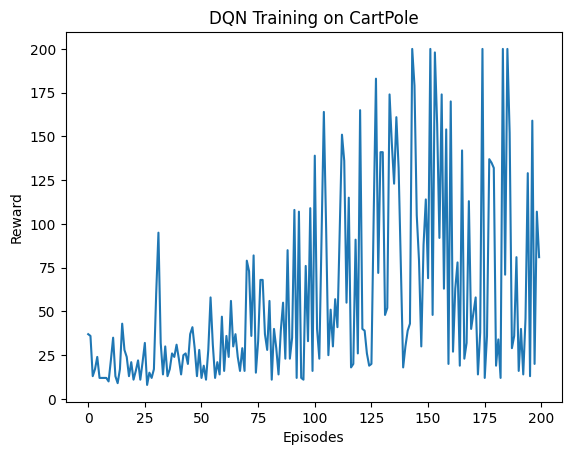

In [53]:
# Function To Perform Action Given State and Policy net and Epsilon and Action Dimensions
def select_action(state, policy_net, epsilon, action_dim):
    if random.random() < epsilon:
        return random.randrange(action_dim)
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            return policy_net(state).argmax(dim=1).item()

# Train the DQN
def train_dqn(policy_net, target_net, memory, optimizer):
    if len(memory) < BATCH_SIZE:
        return


    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    

    states = torch.tensor(np.array(batch.state), dtype=torch.float32)
    actions = torch.tensor(np.array(batch.action), dtype=torch.int64).unsqueeze(1) 
    rewards = torch.tensor(np.array(batch.reward), dtype=torch.float32)
    next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32)
    dones = torch.tensor(np.array(batch.done), dtype=torch.float32)  


    # # Q-values for the current state-action pairs
    current_q_values = policy_net(states).gather(1, actions)

    # # Q-values for the next states
    next_q_values = target_net(next_states).max(1)[0].detach()
    target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

    # # Compute loss
    loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
    
    
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main Loop
env = gym.make(ENV_NAME)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
trained_model = DQN(state_dim, action_dim)
# trained_model.load_state_dict(torch.load("dqn_cartpole.pth"))  # Replace with your saved model path
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.train()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)



rewards = []

for episode in range(EPISODES):
    state = env.reset()[0]
    episode_reward = 0

    for t in range(200):
        action = select_action(state, policy_net, epsilon, action_dim)
        next_state, reward, done, truncated, __= env.step(action)
        memory.push(state, action, next_state, reward, done)
        state = next_state
        episode_reward += reward

        train_dqn(policy_net, target_net, memory, optimizer)

        if done or truncated:
            break

    # Decay epsilon
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    rewards.append(episode_reward)
    print(f"Episode {episode}, Reward: {episode_reward}, Epsilon: {epsilon:.2f}")

# Save the trained model
torch.save(policy_net.state_dict(), "dqn_cartpole.pth")

# Plot rewards
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('DQN Training on CartPole')
plt.show()

In [55]:
# Testing the Model Performance

env = gym.make("CartPole-v1",render_mode="human")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Load the trained DQN model
policy_net = DQN(state_dim, action_dim)
policy_net.load_state_dict(torch.load("dqn_cartpole.pth"))  # Replace with your saved model path
policy_net.eval()  # Set the model to evaluation mode

def play_cartpole(env, policy_net, episodes=5, render=True):
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()[0]
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        episode_reward = 0
        done = False
        truncated = False
        while not done and not truncated:
            if render:
                env.render()

            # Use the model to select the best action
            with torch.no_grad():
                q_values = policy_net(state)
                action = torch.argmax(q_values).item()

            # Perform the selected action
            next_state, reward, done, truncated,__= env.step(action)
            episode_reward += reward

            # Update state
            state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    env.close()
    print(f"Average reward over {episodes} episodes: {np.mean(total_rewards)}")

# Test the trained model
play_cartpole(env, policy_net, episodes=5, render=True)

Episode 1: Reward = 170.0
Episode 2: Reward = 167.0
Episode 3: Reward = 155.0
Episode 4: Reward = 162.0
Episode 5: Reward = 181.0
Average reward over 5 episodes: 167.0


In [56]:
# Random Actions Model
env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset()

episode_over = False
while not episode_over:
    action = env.action_space.sample() 
    observation, reward, terminated, truncated, info = env.step(action)

    episode_over = terminated or truncated

env.close()